In [1]:
import torch
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm, trange
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline

import os, sys, re, gc, glob
from tqdm.auto import tqdm, trange
from utils import JDIDataset, JDIModel, get_grey_image, assign_labels, accuracy



import seaborn as sns

2021-05-18 16:23:01,561 -INFO - common:common.py:422 - Module utils.common is loaded...
2021-05-18 16:23:01,561 -INFO - dataset_builder:dataset_builder.py:16 - dataset package is loaded...
2021-05-18 16:23:01,571 -INFO - dataset:dataset.py:627 - dataset package is loaded...


In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

In [3]:
DEVICE='cpu'

In [4]:
model = torch.load('model/model.pth').to(DEVICE)
model.eval()

JDIModel(
  (input_layer): Linear(in_features=2231, out_features=64, bias=False)
  (batchNorm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (leaky_relu1): LeakyReLU(negative_slope=0.1, inplace=True)
  (hidden1): Linear(in_features=64, out_features=32, bias=False)
  (batchNorm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (leaky_relu2): LeakyReLU(negative_slope=0.1, inplace=True)
  (hidden2): Linear(in_features=32, out_features=21, bias=True)
)

## Load test dataset

In [5]:
# dataset_name = 'angular'
# dataset_name = 'html-5'
# dataset_name = 'react-ant'
# dataset_name = 'mobile-and-html-5'
dataset_name = 'bootstrap'
# dataset_name = 'dummy'
# dataset_name = 'google'
# dataset_name = 'cnews'

In [6]:
dataset = JDIDataset(dataset_names=[dataset_name], rebalance=False)

2021-05-18 16:23:03,924 -INFO - dataset:dataset.py:235 - List of dataset_names:['bootstrap']
2021-05-18 16:23:03,924 -INFO - dataset:dataset.py:241 - Dataset for bootstrap
2021-05-18 16:23:04,008 -INFO - dataset:dataset.py:243 - Dataset shape: (1098, 13)
2021-05-18 16:23:04,008 -INFO - dataset:dataset.py:245 - cleaning tag_name from dummy/auxiliary words
2021-05-18 16:23:04,008 -INFO - dataset:dataset.py:44 - select all leafs (nodes which are not parents)
2021-05-18 16:23:04,022 -INFO - dataset:dataset.py:47 - Leafs set size: 536 (nodes which have no children)
2021-05-18 16:23:04,024 -INFO - dataset:dataset.py:50 - count number of references to leafs
2021-05-18 16:23:04,025 -INFO - dataset:dataset.py:54 - Nodes with leafs as children set size: 373 (nodes which have leafs as children)
2021-05-18 16:23:04,027 -INFO - dataset:dataset.py:57 - count num children for each node
2021-05-18 16:23:04,028 -INFO - dataset:dataset.py:59 - Nodes with children: 563
2021-05-18 16:23:04,029 -INFO - dat

  0%|          | 0/1098 [00:00<?, ?it/s]

2021-05-18 16:23:05,968 -INFO - dataset:dataset.py:260 - Dataset shape after merging with parents: (1098, 44)
2021-05-18 16:23:05,968 -WARNING - dataset:dataset.py:266 - Load LABELS from dataset/annotations/bootstrap.txt


Assigning labels:   0%|          | 0/264 [00:00<?, ?it/s]

2021-05-18 16:23:06,843 -INFO - dataset:dataset.py:282 - Concatenate datasets
2021-05-18 16:23:06,858 -INFO - dataset:dataset.py:284 - Dataset shape after reading: (1098, 46)
2021-05-18 16:23:06,861 -WARNING - dataset:dataset.py:607 - Loading count vectorizer for column "cv_class": model/count_vectorizer_class.pkl
2021-05-18 16:23:06,867 -INFO - dataset:dataset.py:624 - class_sm: (1098, 779)
2021-05-18 16:23:06,869 -INFO - dataset:dataset.py:293 - Build OHE column for attribute role
2021-05-18 16:23:06,873 -INFO - dataset:dataset.py:293 - Build OHE column for attribute type
2021-05-18 16:23:06,876 -INFO - dataset:dataset.py:293 - Build OHE column for attribute ui
2021-05-18 16:23:06,881 -INFO - dataset:dataset.py:298 - Build OHE column for attribute role_parent
2021-05-18 16:23:06,885 -INFO - dataset:dataset.py:298 - Build OHE column for attribute type_parent
2021-05-18 16:23:06,889 -INFO - dataset:dataset.py:298 - Build OHE column for attribute ui_parent
2021-05-18 16:23:06,893 -INFO 

In [7]:
dataset.dataset.shape

(1098, 55)

In [8]:
dataset.labels

0        n/a
1        n/a
2        n/a
3        n/a
4        n/a
        ... 
1093    link
1094     n/a
1095    link
1096     n/a
1097     n/a
Name: label, Length: 1098, dtype: object

In [9]:
dataset.dataset.label

0       20
1       20
2       20
3       20
4       20
        ..
1093     1
1094    20
1095     1
1096    20
1097    20
Name: label, Length: 1098, dtype: int32

In [10]:
dataloader=DataLoader(dataset, shuffle=False, batch_size=1, collate_fn=dataset.collate_fn, pin_memory=True)

In [11]:
results = []
with trange(len(dataloader)) as bar:
    with torch.no_grad():
        for x, y in dataloader:
           
            y_pred = torch.round(torch.nn.Softmax(dim=1)(model(x.to(DEVICE)).to('cpu'))).detach().numpy()
            y_pred = y_pred[0].argmax()
            y = y.item()           
            
            results.append({
                'y_true': y,
                'y_pred': y_pred,
                'y_true_label': dataset.classes_reverse_dict[y], 
                'y_pred_label': dataset.classes_reverse_dict[y_pred]
            })
            bar.update(1)

results_df = pd.DataFrame(results)
results_df

  0%|          | 0/1098 [00:00<?, ?it/s]

,y_true,y_pred,y_true_label,y_pred_label
0,20,20,n/a,n/a
1,20,20,n/a,n/a
2,20,20,n/a,n/a
3,20,20,n/a,n/a
4,20,20,n/a,n/a
...,...,...,...,...
1093,1,1,link,link
1094,20,20,n/a,n/a
1095,1,1,link,link
1096,20,20,n/a,n/a


In [12]:
list(dataset.classes_dict.keys())

['button',
 'link',
 'iframe',
 'textfield',
 'dropdown',
 'checkbox',
 'textarea',
 'label',
 'text',
 'fileinput',
 'image',
 'colorpicker',
 'range',
 'progressbar',
 'datetimeselector',
 'numberselector',
 'dropdownselector',
 'checklist',
 'radiobutton',
 'table',
 'n/a']

In [13]:
confusion_matrix_df = pd.DataFrame(
    confusion_matrix(y_true=results_df.y_true_label.values,
                     y_pred=results_df.y_pred_label.values, 
                     labels=list(dataset.classes_dict.keys())
                    ), 
    #columns=list(dataset.classes_dict.keys()),
    #index=list(dataset.classes_dict.keys())
)



In [14]:
confusion_matrix_df

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,32,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,195,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,15,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,7,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,6,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
import seaborn as sns


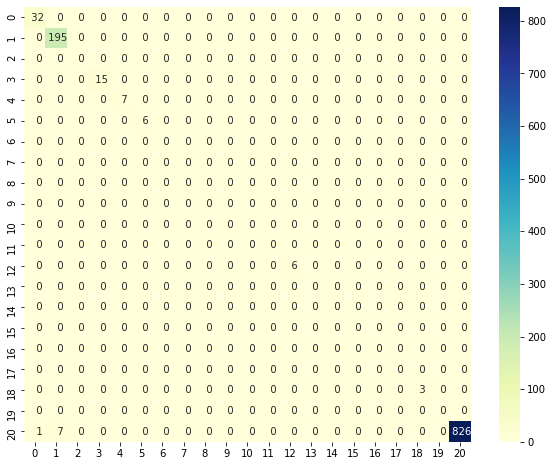

In [16]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix_df, annot=True, fmt="4d", cmap="YlGnBu");

In [17]:
dataset_name

'bootstrap'

In [18]:
accuracy(results_df)

2021-05-18 16:23:09,455 -INFO - common:common.py:457 - Accuracy:  264/272 = 0.9705882352941176, for 1098 elements


0.9705882352941176

In [19]:
dataset.classes_dict

{'button': 0,
 'link': 1,
 'iframe': 2,
 'textfield': 3,
 'dropdown': 4,
 'checkbox': 5,
 'textarea': 6,
 'label': 7,
 'text': 8,
 'fileinput': 9,
 'image': 10,
 'colorpicker': 11,
 'range': 12,
 'progressbar': 13,
 'datetimeselector': 14,
 'numberselector': 15,
 'dropdownselector': 16,
 'checklist': 17,
 'radiobutton': 18,
 'table': 19,
 'n/a': 20}

In [20]:

dataset.dataset['label_text_predicted'] = results_df.y_pred_label


(8310, 1200)


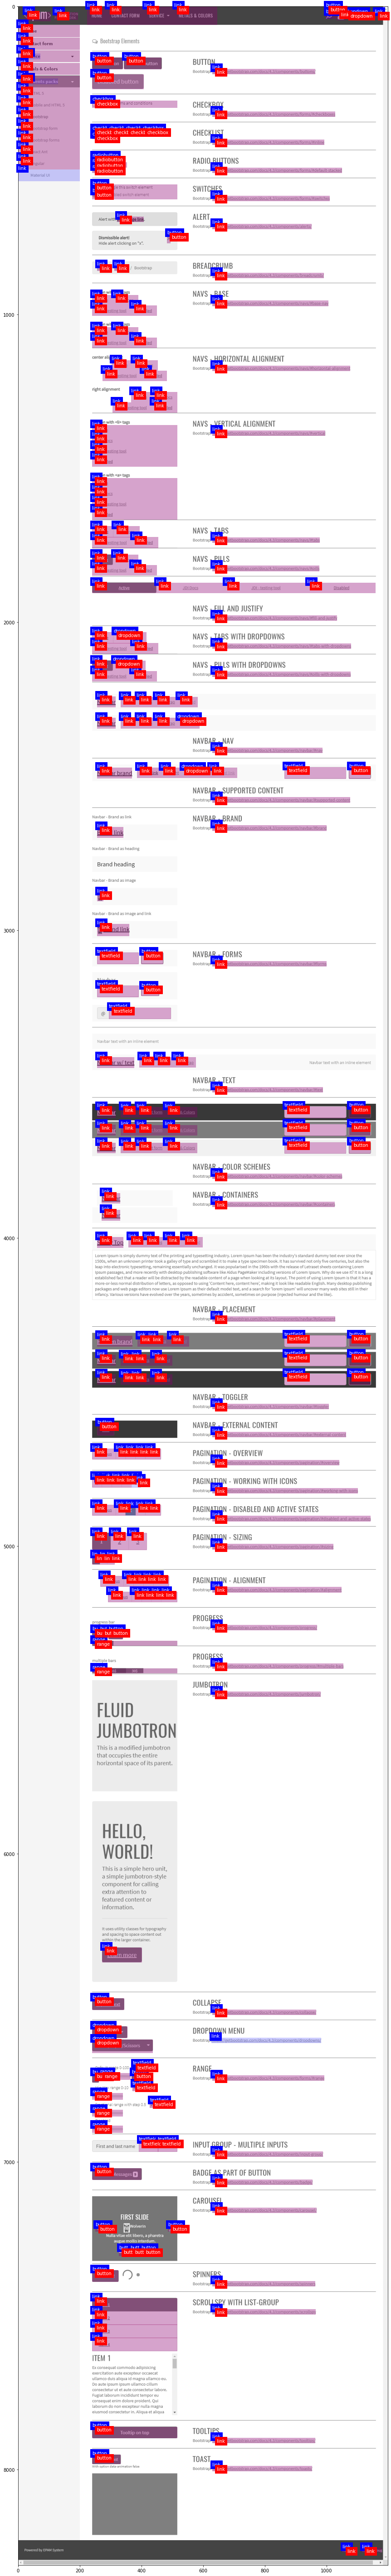

In [21]:
gray_img = get_grey_image(f'dataset/images/{dataset_name}.png')
print(gray_img.shape)

IMG_SIZE = 15
_h = gray_img.shape[0]/gray_img.shape[1]*IMG_SIZE
_w = IMG_SIZE
plt.figure(figsize=(_w, _h))

plt.imshow(gray_img, cmap='gray')
axes = plt.gca()

for i, r in dataset.dataset[dataset.dataset.label_text_predicted != 'n/a'].iterrows():
    #print(r.predicted_label, r.x, r.y, r.width, r.height)
    
    if (r.x<0) or (r.y<0): # or (r.x>r.width): #or (r.y>r.height):
        continue
        
    patch = Rectangle((r.x, r.y), r.width, r.height, linewidth=2, alpha = .2, facecolor = 'blue')
    axes.add_patch(patch)
    axes.text(r.x, r.y, r.label_text_predicted, color='white', backgroundcolor='blue')

for i, r in dataset.dataset[dataset.dataset.label != dataset.dummy_class_value].iterrows():
    #print(r.predicted_label, r.x, r.y, r.width, r.height)
    patch = Rectangle((r.x, r.y), r.width, r.height, linewidth=2, alpha = .2, facecolor = 'red')
    axes.add_patch(patch)
    axes.text(r.x+15, r.y+15, dataset.classes_reverse_dict[r.label], color='white', backgroundcolor='red')
    




In [22]:
results_df

,y_true,y_pred,y_true_label,y_pred_label
0,20,20,n/a,n/a
1,20,20,n/a,n/a
2,20,20,n/a,n/a
3,20,20,n/a,n/a
4,20,20,n/a,n/a
...,...,...,...,...
1093,1,1,link,link
1094,20,20,n/a,n/a
1095,1,1,link,link
1096,20,20,n/a,n/a


In [23]:
dataset.dataset[:1].to_json(orient='records')

'[{"attributes":{"alt":null,"aria-atomic":null,"aria-controls":null,"aria-current":null,"aria-describedby":null,"aria-disabled":null,"aria-expanded":null,"aria-haspopup":null,"aria-hidden":null,"aria-label":null,"aria-labelledby":null,"aria-live":null,"aria-valuemax":null,"aria-valuemin":null,"aria-valuenow":null,"charset":null,"checked":null,"class":null,"content":null,"data-animation":null,"data-dismiss":null,"data-offset":null,"data-original-title":null,"data-pause":null,"data-placement":null,"data-slide":null,"data-slide-to":null,"data-spy":null,"data-target":null,"data-toggle":null,"dir":null,"disabled":null,"dy":null,"fill":null,"focusable":null,"for":null,"height":null,"href":null,"http-equiv":null,"id":null,"index":null,"lang":"en","language":null,"max":null,"min":null,"name":null,"onchange":null,"onclick":null,"oncontextmenu":null,"ondblclick":null,"oninput":null,"placeholder":null,"preserveAspectRatio":null,"rel":null,"role":null,"src":null,"step":null,"style":null,"tabindex"